<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 1 / NOTE 3*

---

# Ridge Regression

- 범주형(Cagegorical) 자료를 다루기 위한 원핫인코딩(One-hot encoding) 기법을 이해합니다.
- 일변량 통계 기반 특성선택(Feature Selection) 과정을 이해합니다.
- 정규화(regularization)을 위한 Ridge 회귀모델을 이해하고 사용할 수 있습니다.

### Warm up

다음 영상을 시청하세요.
- [StatQuest video on Ridge Regression:](https://youtu.be/Q81RR3yKn30?t=222)
    - ridge regression을 통해서 bias를 약간 높이게 되면 어떤 효과를 얻게 되나요?
    - 람다(패널티) 값을 크게 잡으면 어떤 효과가 있나요?


설치해야 하는 라이브러리
- category_encoders (onehot encoding 라이브러리)
      

In [ ]:
# 필요한 라이브러리를 설치합니다.
!pip install scikit-learn==0.24.2
!pip install category_encoders

---

### 원핫인코딩을 살펴보기 위한 간단한 데이터를 준비해 봅시다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    'City': ['Seoul', 'Seoul', 'Seoul', 'Busan', 'Busan', 'Busan', 'Incheon', 'Incheon', 'Seoul', 'Busan', 'Incheon'],
    'Room': [3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 2],
    'Price': [55000, 61000, 44000, 35000, 53000, 45000, 32000, 51000, 50000, 40000, 30000]
})

In [ ]:
# 데이터를 살펴봅니다.
df

,City,Room,Price
0,Seoul,3,55000
1,Seoul,4,61000
2,Seoul,3,44000
3,Busan,2,35000
4,Busan,3,53000
5,Busan,3,45000
6,Incheon,3,32000
7,Incheon,3,51000
8,Seoul,3,50000
9,Busan,3,40000


이처럼 데이터에 문자열(String)을 만나게 되면 어떻게 처리해야 할까요? City 칼럼에 있는 데이터는 도시 지역을 구분하는 범주형 변수(Categorical vaiable)입니다.

범주형 자료는 순서가 없는 **명목형(nominal)**과, 순서가 있는 **순서형(ordinal)**으로 나뉩니다.

도시는 높고 낮음이나 우선순위를 나타낼 필요가 없고 단지 구분만 되면 되기 때문에 명목형 범주형 변수로 보면 됩니다.

#### 범주형 변수를 원핫인코딩으로 변환하는 방법에 대한 모식도를 보겠습니다.

![one-hot](https://i.imgur.com/mtimFxh.png)
- color 변수를 원핫인코딩으로 변환해서 가능한 모든 범주를 열로 나타내었습니다.([one-hot-encoding](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding))

데이터를 살펴보겠습니다.

In [ ]:
## City의 범주 비율을 살펴보겠습니다.
df['City'].value_counts(normalize=True)

Busan      0.363636
Seoul      0.363636
Incheon    0.272727
Name: City, dtype: float64

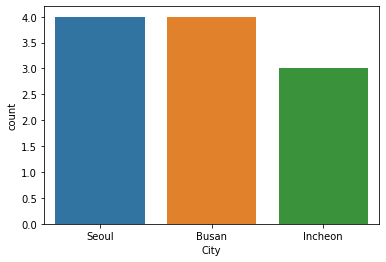

In [ ]:
## seaborn countplot, City
sns.countplot(x=df['City']);

In [ ]:
## Price 평균
df['Price'].mean()

45090.90909090909

In [ ]:
## City 각 범주에 대한 Price 값의 평균을 보겠습니다.
df.groupby('City')['Price'].mean()

City
Busan      43250.000000
Incheon    37666.666667
Seoul      52500.000000
Name: Price, dtype: float64

In [ ]:
## aggregation을 사용해 City 각 범주에 대한 여러 통계량을 볼 수도 있습니다.(min, max, mean, median)
df.groupby('City')['Price'].agg(['min','max','mean','median'])

,min,max,mean,median
City,,,,
Busan,35000,53000,43250.000000,42500
Incheon,30000,51000,37666.666667,32000
Seoul,44000,61000,52500.000000,52500


원핫인코딩을 수행하면 각 카테고리에 해당하는 변수들이 모두 차원에 더해지게 됩니다. 그러므로 카테고리가 너무 많은 경우(high cardinality)에는 사용하기 적합하지 않습니다. 

[집합의크기(Cardinality)](https://simple.wikipedia.org/wiki/Cardinality):

> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3.

* City의 각 범주를 1,2,3 이렇게 순서형 인코딩(ordinal encoding)를 하면 범주형 값들이 대소관계를 가지므로 주의해야 합니다.

우선 pandas get_dummies를 사용하여 간단하게 원핫인코딩을 수행해 봅시다.

In [ ]:
## get_dummies 를 사용한 원핫인코딩
df_oh = pd.get_dummies(df, prefix=['City'])

df_oh

,Room,Price,City_Busan,City_Incheon,City_Seoul
0,3,55000,0,0,1
1,4,61000,0,0,1
2,3,44000,0,0,1
3,2,35000,1,0,0
4,3,53000,1,0,0
5,3,45000,1,0,0
6,3,32000,0,1,0
7,3,51000,0,1,0
8,3,50000,0,0,1
9,3,40000,1,0,0


In [ ]:
## 불필요한 요소를 없인 더미 코딩
df_dum = pd.get_dummies(df, prefix=['City'], drop_first=True)
df_dum

,Room,Price,City_Incheon,City_Seoul
0,3,55000,0,1
1,4,61000,0,1
2,3,44000,0,1
3,2,35000,0,0
4,3,53000,0,0
5,3,45000,0,0
6,3,32000,1,0
7,3,51000,1,0
8,3,50000,0,1
9,3,40000,0,0


### 간단한 선형회귀 모델을 만들어 원핫인코딩 특성을 사용해 보겠습니다.

In [ ]:
## import LinearRegression
from  sklearn.linear_model import LinearRegression

## Initialize LinearRegression
model_oh = LinearRegression()

In [ ]:
## 모델 학습(fit)
model_oh.fit(df_oh[['City_Seoul','City_Busan','City_Incheon']], df_oh['Price'])

LinearRegression()

In [ ]:
## model coef_, intercept_
print("coefficients: ", model_oh.coef_)
print("intercept:" , model_oh.intercept_)

coefficients:  [ 8027.77777778 -1222.22222222 -6805.55555556]
intercept: 44472.22222222222


In [ ]:
# 더미 코딩
model_dum = LinearRegression()
model_dum.fit(df_oh[['City_Seoul', 'City_Incheon']], df_oh['Price'])
print("coefficient: ", model_dum.coef_)
print("intercept: ", model_dum.intercept_)

coefficient:  [ 9250.         -5583.33333333]
intercept:  43250.0


In [ ]:
import plotly.express as px
px.scatter(
    df_oh,
    x='City_Seoul',
    y='Price',
    trendline='ols'
)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
import plotly.express as px
px.scatter(
    df_oh,
    x='City_Busan',
    y='Price',
    trendline='ols'
)

#### Category_encoders
category_encoders 라이브러리를 사용하면 범주형 데이터에만('City') 원핫인코딩을 수행할 수 있습니다.
- [OneHotEncoder](https://contrib.scikit-learn.org/category_encoders/onehot.html)
- [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding)
    - A set of scikit-learn-style transformers for encoding categorical variables into numeric by means of different techniques.

In [ ]:
features = ['City','Room']
target = 'Price'

# 이번에는 훈련/테스트 데이터를 분리해 만들어 보겠습니다.
X_train = df[features][:8]
y_train = df[target][:8]
X_test = df[features][8:]
y_test = df[target][8:]

카테고리값을 원핫인코딩을 사용하여 숫자로 변환합니다

In [ ]:
!pip install category_encoders

In [ ]:
## import OneHotEncoder
from category_encoders import OneHotEncoder

## 원핫 인코딩
encoder = OneHotEncoder(use_cat_names = True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


category_encoders를 사용하면 범주형변수를 가진 특성만 원핫인코딩을 수행합니다.

In [ ]:
## show X_train
X_train.head()

,City_Seoul,City_Busan,City_Incheon,Room
0,1,0,0,3
1,1,0,0,4
2,1,0,0,3
3,0,1,0,2
4,0,1,0,3


In [ ]:
## show X_test
X_test

,City_Seoul,City_Busan,City_Incheon,Room
8,1,0,0,3
9,0,1,0,3
10,0,0,1,2


#### 킹카운티 주택 가격 데이터를 사용해서 특성 선택(feature selection)에 관해 배워보겠습니다.

In [ ]:
# import house data
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/kc_house_data/kc_house_data.csv')

In [ ]:
## show columns
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [ ]:
## show info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
## date 특성
df['date']

0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object

In [ ]:
## to_datetime을 통해 시간과 날짜를 다루기 쉬운 datetime64 형태로 변환합니다.
df['date'] = pd.to_datetime(df['date'])

In [ ]:
## 변환된 date를 정렬해서 보겠습니다. 저장되지는 않습니다.
df['date'].sort_values()

16768   2014-05-02
9596    2014-05-02
9587    2014-05-02
20602   2014-05-02
11577   2014-05-02
           ...    
7898    2015-05-14
928     2015-05-14
5637    2015-05-15
13053   2015-05-24
16594   2015-05-27
Name: date, Length: 21613, dtype: datetime64[ns]

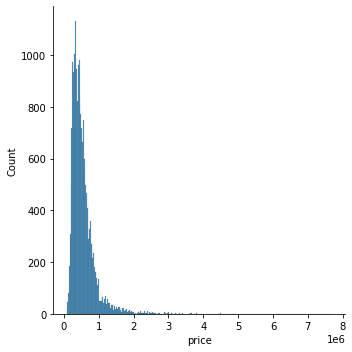

In [ ]:
## displot, 'price'
sns.displot(df['price']);

price 값이 상위 5%, 하위 5%인 데이터를 삭제해 봅시다

In [ ]:
# np.percentile 사용해 이상치 제거
df = df[(df['price'] >= np.percentile(df['price'], 5)) & 
        (df['price'] <= np.percentile(df['price'], 95))] 

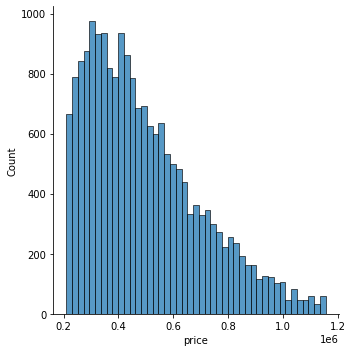

In [ ]:
# displot, 'price'
sns.displot(df['price']);

In [ ]:
## 2015-03-01을 기준으로 훈련/테스트 세트를 분리합니다.
cutOff = pd.to_datetime('2015-03-01')
train = df[df['date'] < cutOff]
test  = df[df['date'] >= cutOff]

In [ ]:
## train/test shape
train.shape, test.shape

((15208, 21), (4303, 21))

## 특성 선택(Feature selection)

특성공학(feature engineering)이 무엇일까요?
- [Wiki, Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

**특성공학**은 과제에 적합한 특성을 만들어 내는 과정입니다. 이 프로세스는 실무 현장에서 가장 많은 시간이 소요되는 작업 중 하나입니다.

이제 사이킷런의 SelectKBest를 사용해서 회귀모델에 중요한 특성을 선택해 보겠습니다.
- [SelectKBest](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

In [ ]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

**Feature description**
- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment,
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Lattitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

#### 특성 선택에 앞서 몇가지 새로운 특성들를 생성하고 지워 봅시다.

In [ ]:
def engineer_features(X):

    # pandas.DataFrame.copy()
    X = X.copy()
    
    ## 욕실 갯수을 정수형으로 처리합니다.
    X['bathrooms'] = X['bathrooms'].round(0).astype(int)

    ## 총 방 수를 합하여 rooms로 합쳐 봅시다.
    X['rooms'] = X['bedrooms'] + X['bathrooms']


    ## 사용하지 않을 특성을 삭제합니다.
    X = X.drop(['id', 'date', 'waterfront'],axis=1)

    return X

train = engineer_features(train)
test = engineer_features(test)

In [ ]:
# 변경된 테이블을 확인합니다.
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms
0,221900.0,3,1,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4
1,538000.0,3,2,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,5
3,604000.0,4,3,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,7
4,510000.0,3,2,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5
6,257500.0,3,2,1715,6819,2.0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5


이런 방법으로 선택 가능한 특성들의 가지수를 계산해 봅시다.
[참고해 보세요, combinations](https://en.wikipedia.org/wiki/Combination)

In [ ]:
from math import factorial

n = len(train.columns)

def n_choose_k(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

combinations = sum(n_choose_k(n,k) for k in range(1,n+1))

combinations

# print(f'{combinations:,.0f}')

524287.0

이렇게 가능한 방법이 많은데 어떻게 필요한 좋은 특성들만 뽑을 수 있을까요? 이것을 수작업으로 할 수 없으니 SelectKBest를 사용해서 유용한 특성들을 찾아 봅시다.

[Scikit-Learn User Guide on Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [ ]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms
0,221900.0,3,1,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4
1,538000.0,3,2,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,5
3,604000.0,4,3,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,7
4,510000.0,3,2,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5
6,257500.0,3,2,1715,6819,2.0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5


#### 데이터를 훈련/테스트 데이터로 분리합니다.

In [ ]:
target = 'price'

## X_train, y_train, X_test, y_test 데이터로 분리
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

#### SelectKBest를 사용해 가장 효과적인 특성 K개를 골라보겠습니다.

In [ ]:
# target(Price)와 가장 correlated 된 features 를 k개 고르는 것이 목표입니다.

## f_regresison, SelectKBest
from sklearn.feature_selection import f_regression, SelectKBest

## selctor 정의합니다.
selector = SelectKBest(score_func=f_regression, k=10)

## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)

## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)


X_train_selected.shape, X_test_selected.shape

((15208, 10), (4303, 10))

#### 선택된 특성을 보겠습니다.

In [ ]:
all_names = X_train.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성들
unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade',
       'sqft_above', 'lat', 'sqft_living15', 'rooms'],
      dtype='object')
Unselected names:  Index(['sqft_lot', 'condition', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'long', 'sqft_lot15'],
      dtype='object')


#### 특성의 수 k 를 어떻게 결정하는게 좋을지 알아 보겠습니다.

1 features
Selected names:  Index(['grade'], dtype='object')
Test MAE: $132,345
Test R2: 0.31754785238363403 

2 features
Selected names:  Index(['sqft_living', 'grade'], dtype='object')
Test MAE: $127,783
Test R2: 0.369134160764375 

3 features
Selected names:  Index(['sqft_living', 'grade', 'sqft_living15'], dtype='object')
Test MAE: $127,304
Test R2: 0.3740237754083221 

4 features
Selected names:  Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15'], dtype='object')
Test MAE: $125,997
Test R2: 0.3843295422396895 

5 features
Selected names:  Index(['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15'], dtype='object')
Test MAE: $126,001
Test R2: 0.3843096242173436 

6 features
Selected names:  Index(['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'lat',
       'sqft_living15'],
      dtype='object')
Test MAE: $101,338
Test R2: 0.5538510966807262 

7 features
Selected names:  Index(['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'lat',
       'sqft_liv

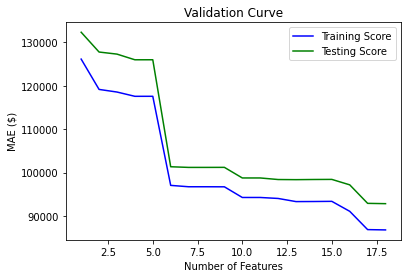

In [ ]:
# features를 몇 개 선책하는 것이 좋은지 알아 봅시다.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

training = []
testing = []
ks = range(1, len(X_train.columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

## Ridge Regression 모델 학습

재미있는 부분은 Ridge 회귀는 기존 다중회귀선을 훈련데이터에 덜 적합이 되도록 만든다는 것입니다. 그 결과로 더 좋은 모델이 만들어 집니다.
다음 식을 살펴 보겠습니다.

$\beta_{ridge}$:  $argmin[\sum_{i=1}^n(y_i - \beta_0 - \beta_1x_{i1}-\dotsc-\beta_px_{ip})^2 + \lambda\sum_{j=1}^p\beta_j^2]$

n: 샘플수, p: 특성수, $\lambda$: 튜닝 파라미터(패널티)
참고: alpha, lambda, regularization parameter, penalty term 모두 같은 뜻 입니다.

Ridge 회귀를 사용하는 이유는 무엇일까요?
Ridge 회귀는 **과적합을 줄이기 위해서** 사용하는 것입니다. 과적합을 줄이는 간단한 방법 중 한 가지는 모델의 복잡도를 줄이는 방법입니다. 특성의 갯수를 줄이거나 모델을 단순한 모양으로 적합하는 것입니다.

앞서 우리는 모델학습에 있어서 편향(bias)과 분산(variance)의 영향에 대해 배웠습니다.
Ridge 회귀는 이 **편향을 조금 더하고, 분산을 줄이는 방법**으로 정규화(Regularization)를 수행합니다.
여기서 말하는 정규화는 모델을 변형하여 과적합을 완화해 일반화 성능을 높여주기 위한 기법을 말합니다.

정규화의 강도를 조절해주는 패널티값인 람다는 다음과 같은 성질이 있습니다.

$\lambda$ → 0,   $\beta_{ridge}$ → $\beta_{OLS}$

$\lambda$ → ∞,   $\beta_{ridge}$ → 0.


### OLS vs Ridge

이제 OLS와 Ridge 회귀를 그래프를 그려보며 비교해 봅시다.

간단히 사용할 데이터는 — [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet), dataset III 입니다:

#### Anscome's quartet 데이터를 불러옵니다.

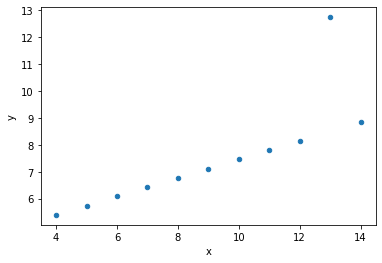

In [ ]:
import seaborn as sns
ans = sns.load_dataset('anscombe').query('dataset=="III"')
ans.plot.scatter('x', 'y');

#### OLS

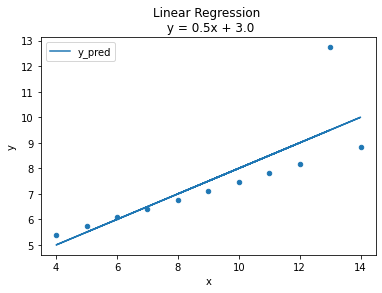

In [ ]:
%matplotlib inline

ax = ans.plot.scatter('x', 'y')

# OLS 
ols = LinearRegression()
ols.fit(ans[['x']], ans['y'])

# 회귀계수와 intercept를 확인합니다.
m = ols.coef_[0].round(2)
b = ols.intercept_.round(2)
title = f'Linear Regression \n y = {m}x + {b}'

# 훈련 데이터로 예측을 합니다.
ans['y_pred'] = ols.predict(ans[['x']])

ans.plot('x', 'y_pred', ax=ax, title=title);

### Ridge Regression

#### $\lambda$ 값을 증가시키며 그래프를 통해 회귀계수의 변화를 살펴보겠습니다.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 



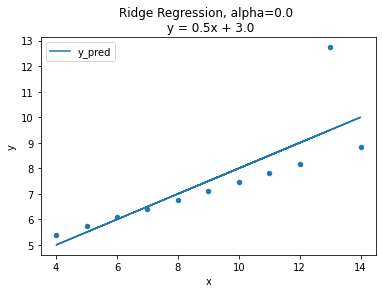

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 



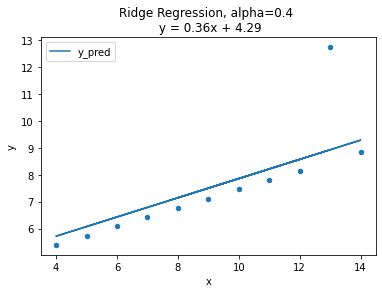

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 



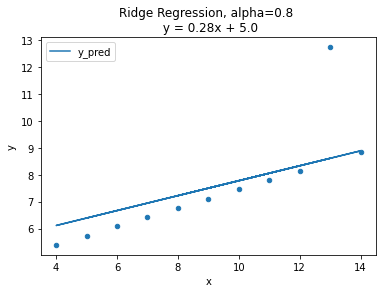

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 



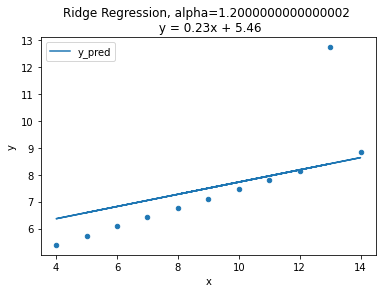

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 



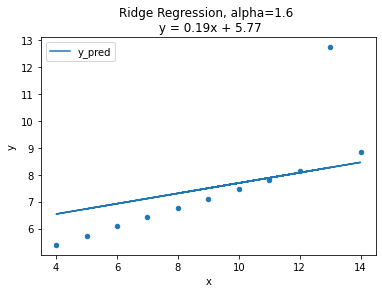

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

def ridge_anscombe(alpha):
    """
    alpha : lambda, penalty term
    """
    ans = sns.load_dataset('anscombe').query('dataset=="III"')

    ax = ans.plot.scatter('x', 'y')

    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(ans[['x']], ans['y'])

    # 회귀계수와 intercept를 가져옵니다.
    m = ridge.coef_[0].round(2)
    b = ridge.intercept_.round(2)
    title = f'Ridge Regression, alpha={alpha} \n y = {m}x + {b}'

    # 예측
    ans['y_pred'] = ridge.predict(ans[['x']])

    ans.plot('x', 'y_pred', ax=ax, title=title)
    plt.show()
    
# 여러 알파값으로 반복해 그래프를 그립니다.
alphas = np.arange(0, 2, 0.4)
for alpha in alphas:
    ridge_anscombe(alpha=alpha)

그래프를 보면, alpha = 0인 경우에는 OLS 와 같은 그래프 형태로 같은 모델 임을 확인 할 수 있고.
alpha 값이 커질 수록 직선의 기울기가 0에 가까워 지면서 평균 기준모델(baseline) 과 비슷해지는 모습을 볼 수 있습니다.

이 패널티값을 보다 효율적으로 구할 수 있는 방법이 있을까요?

[The StatQuest video answers,](https://youtu.be/Q81RR3yKn30?t=602)
> So how do we decide what value to give lambda? We just try a bunch of values for lambda, and use cross-validation
typically 10-fold cross-validation, to determine which one results in the lowest variance.


어떤 특별한 공식이 있는 것은 아니며, 여러 패널티 값을 가지고 검증실험을 해 보는 방법을 사용합니다. 교차검증(Cross-validation)을 사용해 훈련/검증 데이터를 나누어 검증실험을 진행하면 됩니다.(교차검증은 다음 강의에 더 자세히 다룹니다.)

sklearn에서 내장된 교차검증 알고리즘을 적용하는 [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)를 제공합니다.

#### RidgeCV를 통한 최적 패널티(alpha, lambda) 검증

In [ ]:
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.05, 0.1, 0.2, 1.0, 10.0, 100.0]

ridge = RidgeCV(alphas=alphas, normalize=True, cv=3)
ridge.fit(ans[['x']], ans['y'])
print("alpha: ", ridge.alpha_)
print("best score: ", ridge.best_score_)

alpha:  0.2
best score:  0.4389766255562206


다음 Ridge 회귀 직선의 생김새는 OLS매우 비슷하지만 이상치(outlier) 영향을 덜 받습니다.

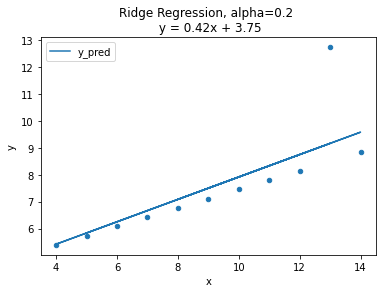

In [ ]:
ax = ans.plot.scatter('x', 'y')

m = ridge.coef_[0].round(2)
b = ridge.intercept_.round(2)
title = f'Ridge Regression, alpha={ridge.alpha_} \n y = {m}x + {b}'

ans['y_pred'] = ridge.predict(ans[['x']])

ans.plot('x', 'y_pred', ax=ax, title=title)
plt.show()

#### House data
이제 다시 집값 예측 데이터로 돌아와서, ridge 회귀의 패널티에 대한 영향을 확인해 보겠습니다. 특성은 sqft_living를 사용해 그래프를 그려보겠습니다.

Ridge Regression, with alpha=0.001
Test MAE: $136,544


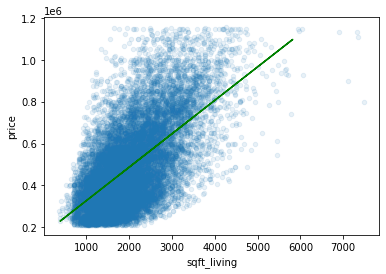

Ridge Regression, with alpha=0.01
Test MAE: $136,539


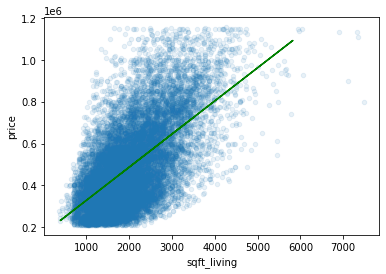

Ridge Regression, with alpha=0.1
Test MAE: $136,740


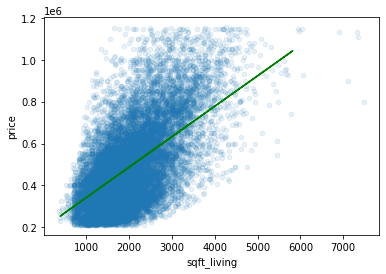

Ridge Regression, with alpha=1.0
Test MAE: $143,916


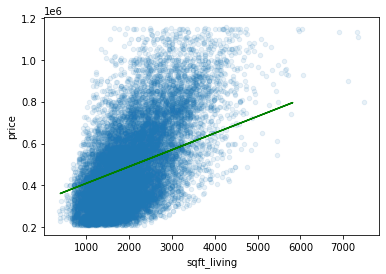

Ridge Regression, with alpha=10.0
Test MAE: $160,541


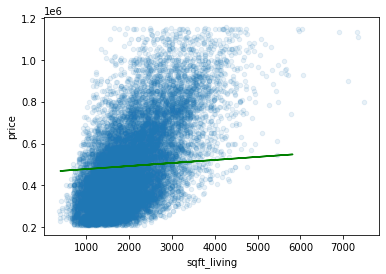

Ridge Regression, with alpha=100.0
Test MAE: $164,673


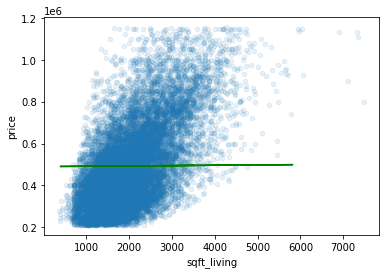

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    feature = 'sqft_living'
    print(f'Ridge Regression, with alpha={alpha}')
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train[[feature]], y_train)

    
    # Get Test MAE
    y_pred = model.predict(X_test[[feature]])    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f}')
    
    train.plot.scatter(feature, target, alpha=0.1)
    plt.plot(X_test[feature], y_pred, color='green')
    plt.show()

### 이번에는 여러 특성을 사용해서 Ridge 회귀를 학습해 봅시다.

Ridge Regression, alpha=0.001
Test MAE: $92,824
Test R2: 0.633


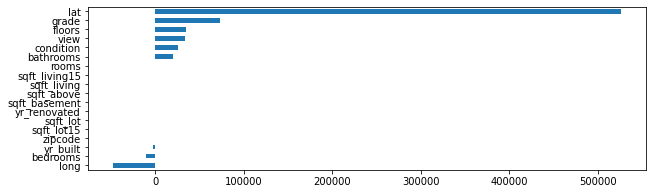

Ridge Regression, alpha=0.005
Test MAE: $92,812
Test R2: 0.633


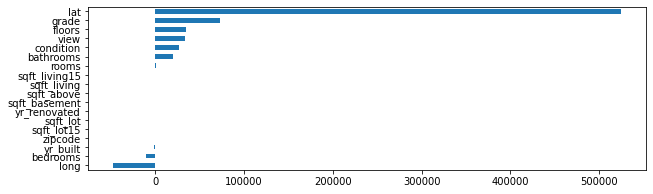

Ridge Regression, alpha=0.01
Test MAE: $92,801
Test R2: 0.633


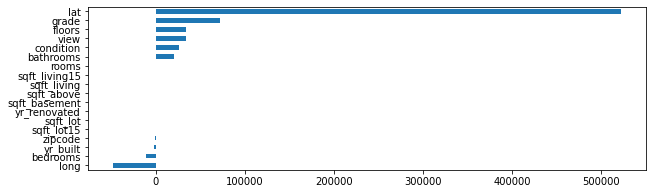

Ridge Regression, alpha=0.02
Test MAE: $92,794
Test R2: 0.632


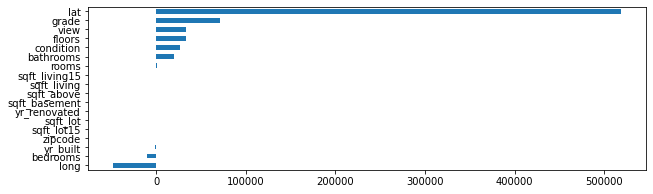

Ridge Regression, alpha=0.03
Test MAE: $92,800
Test R2: 0.632


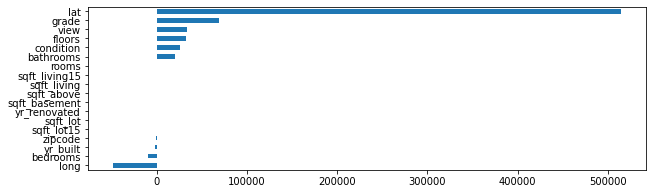

Ridge Regression, alpha=0.1
Test MAE: $93,186
Test R2: 0.627


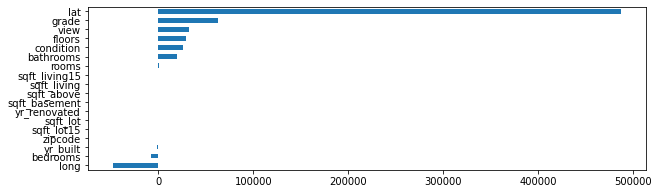

Ridge Regression, alpha=1.0
Test MAE: $107,595
Test R2: 0.536


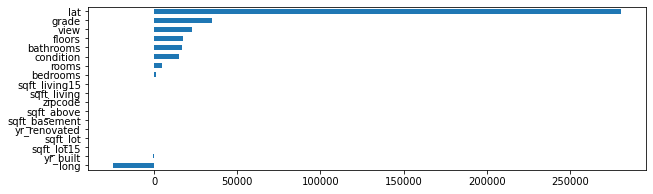

Ridge Regression, alpha=1
Test MAE: $107,595
Test R2: 0.536


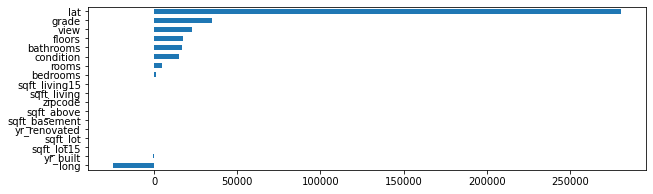

Ridge Regression, alpha=100.0
Test MAE: $162,268
Test R2: 0.033


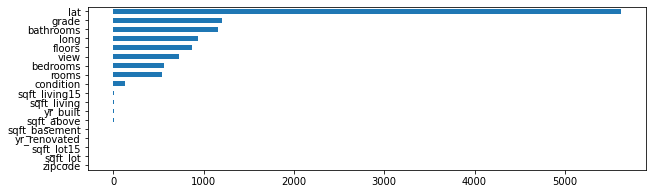

Ridge Regression, alpha=1000.0
Test MAE: $164,890
Test R2: 0.001


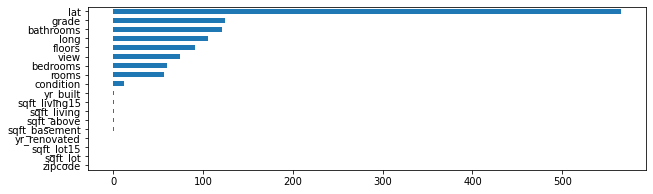

In [ ]:
from sklearn.metrics import r2_score

for alpha in [0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 1.0, 1, 100.0, 1000.0]:
        
    print(f'Ridge Regression, alpha={alpha}')

    # Ridge 모델 학습
    model = Ridge(alpha=alpha, normalize=True)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAE for test
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2:,.3f}')
    
    # plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(10,3))
    coefficients.sort_values().plot.barh()
    plt.show()

### 다항함수에 Ridge 회귀를 적용해 보겠습니다.
다수의 특성을 사용하는 다항함수에 Ridge 회귀를 사용하면 정규화 효과를 더 잘 확인할 수 있습니다.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def RidgeRegression(degree=3, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         Ridge(**kwargs))


for alpha in [0.001, 0.01, 0.0025, 0.05, 0.09, 0.12, 0.4, 1.0, 1, 5, 10, 100]:
        
    print(f'Ridge Regression, alpha={alpha}')

    # Ridge 모델 학습
    model = RidgeRegression(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAE for test
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'R2 Score: {r2:,.4f}\n')

coefs = model.named_steps["ridge"].coef_
print(f'Number of Features: {len(coefs)}')

Ridge Regression, alpha=0.001
Test MAE: $91,018
R2 Score: 0.0060

Ridge Regression, alpha=0.01
Test MAE: $91,045
R2 Score: 0.5376

Ridge Regression, alpha=0.0025
Test MAE: $91,320
R2 Score: 0.2307

Ridge Regression, alpha=0.05
Test MAE: $90,651
R2 Score: 0.6430

Ridge Regression, alpha=0.09
Test MAE: $90,676
R2 Score: 0.6467

Ridge Regression, alpha=0.12
Test MAE: $90,724
R2 Score: 0.6466

Ridge Regression, alpha=0.4
Test MAE: $91,147
R2 Score: 0.6421

Ridge Regression, alpha=1.0
Test MAE: $91,804
R2 Score: 0.6355

Ridge Regression, alpha=1
Test MAE: $91,804
R2 Score: 0.6355

Ridge Regression, alpha=5
Test MAE: $96,994
R2 Score: 0.5987

Ridge Regression, alpha=10
Test MAE: $102,946
R2 Score: 0.5626

Ridge Regression, alpha=100
Test MAE: $128,158
R2 Score: 0.3874

Number of Features: 1330


### 자 이제 마지막으로 최종 모델을 만들어 보도록 하겠습니다.

RidgeCV를 사용하여 최적의 alpha값을 찾아내어 모델 학습을 완료해 보겠습니다.

In [ ]:
def RidgeCVRegression(degree=3, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         RidgeCV(**kwargs))

# alphas = np.linspace(0.01, 0.5, num=20)
alphas = np.arange(0.01, 0.2, 0.01)

model = RidgeCVRegression(alphas=alphas, normalize=True, cv=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')
print(f'R2 Score: {r2:,.4f}\n')

coefs = model.named_steps["ridgecv"].coef_
print(f'Number of Features: {len(coefs)}')

print(f'alpha: {model.named_steps["ridgecv"].alpha_}')
print(f'cv best score: {model.named_steps["ridgecv"].best_score_}') # best score: R2

Test MAE: $90,647
R2 Score: 0.6460

Number of Features: 1330
alpha: 0.06999999999999999
cv best score: 0.6908247029544381


패널티값을 0.07로 주었을 때 cv 점수는 높은데 실제 테스트데이터에서 R2 스코어는 낮게 나오고 있습니다

#### 최종모델

최종 모델을 만들기 위해서는 가지고 있는 데이터를 다 사용해 최적의 모델을 만들어야 합니다.

지금 가지고 있는 테스트 데이터를 검증 데이터로 사용하려면 RidgeCV에 훈련 데이터로 함께 넣어 주어야 합니다.
RidgeCV내에서 훈련 데이터를 훈련/검증 데이터로 나누어 최고 스코어를 가지는 alpha를 찾아 줄 것입니다.

In [ ]:
X_total = pd.concat([X_train, X_test])
y_total = pd.concat([y_train, y_test])

In [ ]:
# 모든 데이터를 사용해 최종 모델을 만듭니다.
model = RidgeCVRegression(alphas=alphas, normalize=True, cv=5)
model.fit(X_total, y_total)

coefs = model.named_steps["ridgecv"].coef_
print(f'Number of Features: {len(coefs)}')

print(f'alpha: {model.named_steps["ridgecv"].alpha_}')
print(f'cv best score: {model.named_steps["ridgecv"].best_score_}')

Number of Features: 1330
alpha: 0.060000000000000005
cv best score: 0.6801974133016854


In [ ]:
coefs.max(), coefs.mean()

(69149.10323353522, 55.70723729013479)

In [ ]:
# 회귀계수들을 정렬합니다.
coefs.sort()

In [ ]:
coefs

array([-1340.15173204, -1124.35937697,  -825.00983454, ...,
        1715.03276605,  3948.7451279 , 69149.10323354])

#### 회귀계수를 그래프로 그려보겠습니다.
몇몇 중요한 특성들만 회귀계수가 크고 대부분 0 근처에 있음을 볼 수 있습니다.

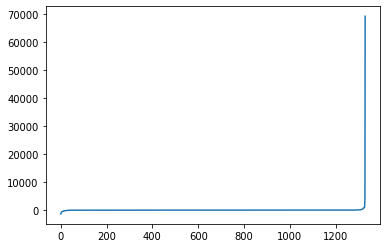

In [ ]:
plt.plot(coefs)

Ridge 회귀는 정규화를 통해 특이값으로 인한 과도한 기울기를 보정해줍니다. 또한 영향력이 낮은 특성의 회귀계수의 값을 감소시켜 특징선택 효과를 가져옵니다.

## 참고자료

- [one-hot-encoding](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding)

### 특성공학
- [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
- [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 
- [Sklearn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)

### Ridge regression
- [Sklearn Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn-linear-model-ridge)
- [Sklearn RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn-linear-model-ridgecv)
- [Modern regression 1: Ridge regression](http://www.stat.cmu.edu/~ryantibs/datamining/lectures/16-modr1.pdf)
- [Regularization: Ridge Regression and the LASSO](http://zhanxw.com/blog/wp-content/uploads/2013/09/Rudyregularization.pdf)



